L'enjeu de ce TP est de pouvoir pr√©dire l'auteur d'un tweet bas√© sur les historiques de publications des potentiels auteurs. 

## **1. Installation des packages**

In [ ]:
!pip install scattertext
!pip install spacy
!pip install nltk
!pip install emot

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7.3MB 9.4MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9299 sha256=7bf5dc9bea6cb6100092493e9c07c129bc98b1359d731458114acd6dc6c29e34
  Stored in directory: /root/.cache/pip/wheels/37/db/d7/fe74f7cb8e5c3afed90fe6f4967c933a6f13d81ab6b3d3128c
Successfully built flashtext


In [ ]:
!python -m spacy download fr_core_news_md

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 88.6MB 1.3MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-cp36-none-any.whl size=90338490 sha256=7c15ac4907113fbe46ad9f7474c3283f10fcc26b16d0167ab498a10cca6c0cf5
  Stored in directory: /tmp/pip-ephem-wheel-cache-yg3miowo/wheels/c6/18/b6/f628642acc7872a53cf81269dd1c394d96da69564ccfac5425
Successfully built fr-core-news-md
‚úî Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Modules de traitement du texte
import spacy
import fr_core_news_md
import nltk
import re
from termcolor import colored
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

# Modules pour le wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Module pour scattertext
import scattertext as st

# Modules de mod√©lisation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report

In [ ]:
# chemin o√π se trouve le jeu de donn√©es (tweets_JLM_MLP_EM.csv)
PATH_DATA = '/content/drive/MyDrive/Colab Notebooks'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


## **2. Prise en main de la base de donn√©es**

Les donn√©es ont √©t√© extraites via l'API tweepy dans un autre notebook. \
Les tweets de Jean-Luc M√©lenchon, de Marine Le Pen et de Emmanuel Macron ont √©t√© r√©cup√©r√©s. 

Regardez les variables √† disposition, quelques comptages, s'il y a des donn√©es manquantes, quelques graphiques (?), la sp√©cificit√© des tweets, etc. 

#### Import des donn√©es

In [ ]:
df_tweets = pd.read_csv('{}/tweets_JLM_MLP_EM.csv'.format(PATH_DATA),encoding="utf-8")

# ou si le csv est directement dans votre jupyter : 
# df_tweets = pd.read_csv('tweets_JLM_MLP_EM.csv')

In [ ]:
df_tweets.shape

(7690, 6)

In [ ]:
df_tweets.head()

id  ...      user_id
0  1355788407344164865  ...  JLMelenchon
1  1355687094627274760  ...  JLMelenchon
2  1355683811976237057  ...  JLMelenchon
3  1355680607657996288  ...  JLMelenchon
4  1355679024404713474  ...  JLMelenchon

[5 rows x 6 columns]

####  Quelques comptages / graphiques

##### Indicateurs simples sur les variables : 
- Y a't'il des donn√©es manquantes ? 
- combien de tweets de MLP et JLM ? 
- dates minimales / maximales des tweets
- Distribution des favoris et des retweets de MLP et JLM

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
    <li> Utiliser .isnull() </li>
    <li><a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html" >pd.value_counts()</a> pour compter le nombre de modalit√©s d'une variable cat√©gorielle </li>
    <li> Convertir la date au bon format avec pd.to_datetime() </li>
    <li> Vous pouvez utiliser la fonction groupby et describe() </li>

</ul>
</p>

In [ ]:
# Impl√©mentez la fonction en changeant le None
def check_missing_values(df):
  print("check for missing values : ")
  print(df.isnull().sum()/len(df))  
  return None

check_missing_values(df_tweets)
# Vous pouvez √©galement utiliser df.info()

check for missing values : 
id                0.0
created_at        0.0
favorite_count    0.0
retweet_count     0.0
text              0.0
user_id           0.0
dtype: float64


In [ ]:
# Combien de tweets dans la base de donn√©es pour chacun des 2 politiques ? 
df_tweets["user_id"].value_counts()
# ou df_tweets["user_id"].value_counts(normalize=True) si vous voulez avoir les pourcentages

EmmanuelMacron    2897
MLP_officiel      2559
JLMelenchon       2234
Name: user_id, dtype: int64

In [ ]:
# A quelles dates ont √©t√© envoy√©s les premiers / derniers tweets de JML et MLP ? 
df_tweets["created_at"] = pd.to_datetime(df_tweets['created_at'])
df_tweets.groupby(["user_id"])["created_at"].apply(lambda x  : [x.min(), x.max()])

user_id
EmmanuelMacron    [2018-05-01 18:40:31, 2021-01-30 17:08:01]
JLMelenchon       [2020-04-19 09:59:47, 2021-01-31 08:02:00]
MLP_officiel      [2019-01-19 16:05:02, 2021-01-29 21:02:28]
Name: created_at, dtype: object

In [ ]:
# Quelle est la distribution des favoris et retweets de MLP et JLM  ?
df_tweets.groupby(["user_id"])[["favorite_count", "retweet_count"]].describe()

favorite_count                             ... retweet_count                
                        count         mean           std  ...           50%    75%      max
user_id                                                   ...                              
EmmanuelMacron         2897.0  5506.235416  13867.602674  ...         448.0  908.0  71405.0
JLMelenchon            2234.0   742.933751   2288.676408  ...          93.0  299.0  27751.0
MLP_officiel           2559.0  1172.197733   1168.385382  ...         341.0  626.0   4219.0

[3 rows x 16 columns]

##### R√©partition du nombre de retweets / favoris dans le temps 

In [ ]:
def visualize_count_favorites(df, userID) : 
  
  ''' Cette fonction permet de visualiser le nombre de favoris et de retweets 
  sur toute la p√©riode pour un user_id donn√© '''

  df_temp = df.loc[df["user_id"] == userID]
  ylabels = ["favorite_count", "retweet_count"]

  print("Repr√©sentation des nombres de retweets et de favoris de chaque tweet de {} par date".format(userID))
  fig = plt.figure(figsize=(13,3))
  fig.subplots_adjust(hspace=0.01,wspace=0.01)

  n_row = len(ylabels)
  n_col = 1
  for count, ylabel in enumerate(ylabels):
      ax = fig.add_subplot(n_row, n_col, count + 1)
      ax.plot(df_temp["created_at"], df_temp[ylabel])
      ax.set_ylabel(ylabel)
  
  plt.show()

Repr√©sentation des nombres de retweets et de favoris de chaque tweet de JLMelenchon par date


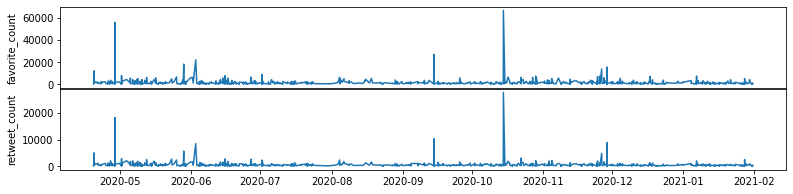



Repr√©sentation des nombres de retweets et de favoris de chaque tweet de MLP_officiel par date


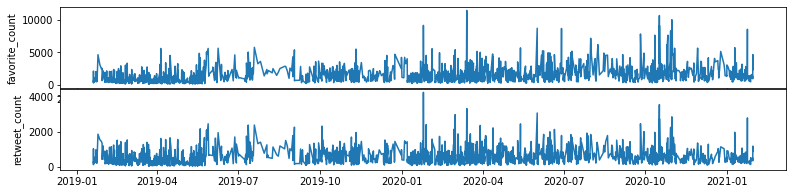

In [ ]:
visualize_count_favorites(df_tweets, "JLMelenchon")
print("\n")
visualize_count_favorites(df_tweets, "MLP_officiel")

> **Question** : Qu'observe-t'on ? 

**R√©ponse** : 
- JLM : 2 tweets ont √©t√© plus de 20K fois retweet√©s (alors qu'en moyenne, un tweet de JLM est retweet√© 280 fois) et ont eu donc une grande popularit√© par rapport √† son audience normale. 
- MLP a plut√¥t une audience stable, avec quelques tweets qui ont √©t√© plus retweet√©s (pic √† 4K alors qu'en moyenne un tweet de MLP est retweet√© 470 fois).

##### Taille des tweets par politique 

Est-ce que les tweets de MLP sont plus/moins longs que ceux de JLM ? 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
    <li> Utilisez la fonction <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html" >.split()</a> pour calculer la taille des tweets</li>
    <li> Vous pouvez utiliser la fonction groupby et describe() </li>

</ul>
</p>

In [ ]:
# Calcul d'une variable contenant le nombre de mots de chaque tweets
df_tweets["lenght_tweet"] = df_tweets["text"].apply(lambda tweet : len(tweet.split()))

# Calcul de la distribution de la variable pour chaque politique
df_tweets.groupby(["user_id"]).lenght_tweet.describe()

count       mean        std  min   25%   50%   75%   max
user_id                                                                  
EmmanuelMacron  2897.0  28.575423  12.003363  1.0  19.0  29.0  39.0  57.0
JLMelenchon     2234.0  30.417189  11.141463  1.0  22.0  31.0  39.0  58.0
MLP_officiel    2559.0  35.613130  10.775029  1.0  30.0  38.0  43.0  55.0

In [ ]:
df_tweets.head(3)

id          created_at  ...      user_id  lenght_tweet
0  1355788407344164865 2021-01-31 08:02:00  ...  JLMelenchon            10
1  1355687094627274760 2021-01-31 01:19:25  ...  JLMelenchon            44
2  1355683811976237057 2021-01-31 01:06:22  ...  JLMelenchon            47

[3 rows x 7 columns]

**R√©ponse** : En moyenne, MLP fait des tweets plus longs que les autres. 

##### Lecture de quelques tweets

In [ ]:
def print_famous_tweets(userID, nb_favorites) :

  ''' Cette fonction permet de s√©lectionner les tweets qui ont eu le plus de favoris 
  pour un user_id donn√©, et de lire le tweet avec les indicateurs des autres variables de la 
  base de donn√©es  
  '''

  df_sub = df_tweets.loc[(df_tweets.user_id==userID) & (df_tweets.favorite_count > nb_favorites),:]
  for irow in range(df_sub.shape[0]):
      df_row = df_sub.iloc[irow,:]
    
      print(df_row["created_at"])
      print("favorite_count={:6} retweet_count={:6}".format(df_row["favorite_count"],df_row["retweet_count"]))
      print(colored(df_row["text"], 'magenta'))
      print("\n")

In [ ]:
print_famous_tweets("JLMelenchon", 20000)

2020-10-14 18:38:21
favorite_count= 66651 retweet_count= 27751
60 % des contaminations ont lieu au travail ou √† l'√©cole ou √† l'universit√© entre 8h et 19h. 

Mais #Macron interdit les sorties au bar et au restau entre 20h et 6h. 

Bienvenue en Absurdie.

#macron20h #CouvreFeu #COVID19france


2020-09-14 13:41:47
favorite_count= 26941 retweet_count= 10319
La haine contre la 2√®me religion du pays n'a donc plus de limite. https://t.co/0latKIG78G


2020-06-02 21:42:01
favorite_count= 21947 retweet_count=  8461
#Castaner ! La violence c'est vous et votre pr√©fet qui la provoquez ! √áa suffit ! Le pays m√©rite mieux que votre jeu d'apprenti sorcier. Donald Trump n'est pas un mod√®le. #JusticePourAdama


2020-04-28 19:56:04
favorite_count= 55881 retweet_count= 18265
J'ai pas compris. Le #11mai il d√©confine les coiffeurs oui ou non ? #DirectAN https://t.co/3s2ml69ful https://t.co/XWTCpZr4j5




In [ ]:
print_famous_tweets("MLP_officiel", 10000)

> **Question** : Qu'y-a't'il de particulier dans les tweets par rapport √† un texte normal ?

**R√©ponse** : On voit que les tweets ont une syntaxe particul√®re : 
- hashtags 
- liens internet
- √©mojis

## **3. Preprocessing du texte**

On va prendre en compte les particularit√©s des tweets pour nettoyer le texte. \
On va tester les techniques de preprocessing des cours pr√©c√©dents sur du texte fran√ßais : 
- stopwords
- lemmatisation
- tokenisation


### Nettoyage du texte
Dans cette partie du TP, on nettoie le texte pour enlever les mots qui vont rajouter du bruit √† l'analyse (et ne rien apporter) \
Pour nettoyer le texte : 
- conversation des emojis en texte
- suppression de certaines expressions gr√¢ce √† des expressions r√©guli√®res
- suppression des stopwords


In [ ]:
# on charge le mod√®le fran√ßais de spacy
nlp = fr_core_news_md.load()

# On rajoute dans des stopwords √† la liste de stopwords propos√©e par spacy
nlp.Defaults.stop_words |= {"mlp","a","faut","faire","monsieur","rendez-vous","direct",
                            "interview",r"invit√©\w+","dit","livetweet","suivez","celui",
                            "ce","cette","emot_right_arrow"}

# nombre de stopwords 
len(nlp.Defaults.stop_words)

611

> **Conseil** :  Regarder toujours la liste enti√®re de stopwords propos√©s pour enlever certains mots qui seraient utiles dans votre √©tude ou rajouter des stopwords non pr√©sents dans la liste

Gr√¢ce au package emot et √† la fonction ci-dessous, vous pouvez convertir les emojis dans les tweets en texte (pour ne pas perdre l'information qu'ils peuvent apporter √† la suite de l'analyse)

In [ ]:
def convert_emojis(text):
  ''' Cette fonction transforme les emojis en texte qui commente par 
  emot_ puis la description en anglais de l'emoji.
  Certains emojis ne sont pas bien convertis (ex : certains drapeaux)'''
  for emot in UNICODE_EMO:
    name_emoticon = "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").replace("&","").split())
    name_emoticon = re.sub(r"[_-]+", "_", name_emoticon)
    name_emoticon = "emot_" + name_emoticon + " "
    text = text.replace(emot, name_emoticon + " ")
  text = re.sub(r"\s+", " ", text)
  return text

replique1 = "La ‚ùì elle est vite r√©pondue ü§ëüôÑ"
replique2 = "Mets-moi des üéâ dans ma vie Kevin ! "

print(convert_emojis(replique1))
print(convert_emojis(replique2))

La emot_question_mark elle est vite r√©pondue emot_money_mouth_face emot_face_with_rolling_eyes 
Mets-moi des emot_party_popper dans ma vie Kevin ! 


Expressions r√©guli√®res pour nettoyer le texte 

In [ ]:
regexp_link = re.compile(r"http\S+") # suppression des liens
regexp_punctuation = re.compile("[,\./<>\?;':\"\[\]\\{}|`~!$%^&*()+-=¬´¬ª‚Äô]") # suppression des ponctuations

# Rajout regexp apr√®s premier scattertext
regexp_frenchflag = re.compile("üá´üá∑")

**TODO** : Cr√©er une expression r√©guli√®re pour supprimer les hashtags et @

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
Lorsque vous cherchez √† cr√©er des expressions r√©guli√®res, vous pouvez vous aider en allant sur ce site : <a href="https://regex101.com/" >regex101.com</a> 
</p> 

In [ ]:
regexp_hashtags = re.compile(r"[#@]\w+")    # suppression des hashtags et @

In [ ]:
test_hashtags = "#Fuck √ßa #ne marche @pas !!"
re.sub(regexp_hashtags, "", test_hashtags)

' √ßa  marche  !!'

Cr√©ation de la fonction de nettoyage du texte 

**TODO** : coder la fonction qui prend en entr√©e un tweet et  
- met les mots en minuscule
- supprime les mots des expressions r√©guli√®res
- supprime les ponctuations
- supprime les stopwords
- lemmatise

In [ ]:
def remove_punct(doc):
  return [token for token in doc if not token.is_punct]


def remove_stop_words(doc):
  return [token for token in doc if not token.is_stop]


def lemmatize(doc):
   return ' '.join([token.lemma_ for token in doc])

In [ ]:
def preprocess_tweet(text, lemmatizing=True, delete_pos=False) : 

  '''Fonction permettant de nettoyer le texte. Elle renvoie un string (pas de tokenisation encore)'''
  
  emojis_converted = convert_emojis(text)
  french_flag_added = re.sub(regexp_frenchflag, "french_flag", emojis_converted)
  text_to_lower = french_flag_added.lower().encode('utf-8').decode('utf-8')
  text_no_link = re.sub(regexp_link, "", text_to_lower)
  text_no_hastags = re.sub(regexp_hashtags, "", text_no_link)
  
  # utilisation de spacy
  doc = nlp(text_no_hastags)
  removed_punct = remove_punct(doc)
  preprocessed_tweet = remove_stop_words(removed_punct)
  if lemmatizing :
    preprocessed_tweet = lemmatize(preprocessed_tweet)
    
  return(preprocessed_tweet)

In [ ]:
# exemple pour tester sa fonction 
tweet_test = "Ils Pensaient se moquer #non, ils m'ont donn√© un slogan !üòÑ \n\n- Entretien √† d√©couvrir et partager \n\nhttps://t.co/Yn60Areagu"
preprocess_tweet(tweet_test, lemmatizing=True, delete_pos=False)

'pensaient moquer donner slogan emot_smiling_face_with_open_mouth_smiling_eyes entretien d√©couvrir partager'


R√©ponse attendue : 
```python 
'pensaient moquer donner slogan emot_smiling_face_with_open_mouth_smiling_eyes entretien d√©couvrir partager'
```

In [ ]:
# On peut alors nettoyer nos tweets, et cr√©er une nouvelle colonne, text_preprocess
# cela peut prendre un peu de temps... 
df_tweets["text_preprocess"] = df_tweets["text"].apply(lambda tweet : preprocess_tweet(tweet))

In [ ]:
# On regarde le r√©sultat du nettoyage du texte
pd.set_option("max_colwidth", None)
df_tweets[["text", "text_preprocess"]].head(5)

text                                                                                                                                                           text_preprocess
0                                                                                                                                                                                                                                    Il faut imaginer une autre fa√ßon de vivre. #OEED https://t.co/LcMraG4YT8                                                                                                                                                  falloir imaginer vivre  
1                    Ils ont transform√© le Bac en marchandise. Et voyez-vous, quand vous n'avez que cette possibilit√© pour vous √©lever dans la vie en √©tudiant s√©rieusement pour avoir un dipl√¥me, vous √™tes √† cran quand il est question de r√©tablir une diff√©rence de classe. #OEED https://t.co/nbNVlhVSU7                               transformer bac marchandise voyez avoir possibilit√© √©lever vie √©tudier s√©rieusement dipl√¥me √™tre cran question r√©tablir diff√©rence classe  
2  La Commune appartient √† l'histoire de France. Comme le pouvoir officiel est incapable de faire quoi que ce soit alors les gens s'organisent. La magie du moment c'est que les gens r√®glent les probl√®mes concrets eux-m√™mes et se mettent √† produire une masse de d√©cisions. #OEED https://t.co/EmHaEJKSa3                       commune appartenir histoire france pouvoir officiel incapable faire organiser magie moment r√©gler probl√®me concret mettre produire masse d√©cision  
3                                                                    Ce qui compte c'est les id√©es, et plus exactement ce qu'on va faire pour ce pays. Par cons√©quent, on ne peut pas faire des soupes aux logos dans lesquelles, pour pouvoir s'entendre, on se tait sur tout. #OEED https://t.co/QvNsSbZ0v6                                                                                               compte id√©e faire pays cons√©quent faire soupe logo pouvoir entendre taire  
4              La situation des √©tudiants √©tait pr√©visible. Au mois de mai, des d√©put√©s insoumis ont mis au point un plan pour les aider. Il faut les tirer de la pr√©carit√©, il y a urgence. Commen√ßons par la question mat√©rielle en donnant le RSA aux jeunes de 18 √† 25 ans. #OEED https://t.co/vEMFH7pc9v  situation √©tudiant pr√©visible mois mai d√©put√© insoumis mettre point plan aider falloir tirer pr√©carit√© y urgence commencer question mat√©riel donner rsa jeune 18 25 an


> Le preprocess n'est pas encore parfait, on pourrait enlever les verbes avec du pos-tagging

### Tokenisation
On tokenise la colonne de tweets pr√©trait√©s (preprocess)

**TODO** : utiliser le module nltk pour tokeniser un tweet avec la fonction tokenisation

In [ ]:
nltk.download('punkt') # n√©cessaire pour la tokenisation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Remplir le None dans le code
def tokenisation(tweet):
  tweet_tokenized = nltk.word_tokenize(tweet)
  return(tweet_tokenized)

In [ ]:
# On peut alors tokeniser nos tweets, et cr√©er une nouvelle colonne, tokens
df_tweets["tokens"] = df_tweets["text_preprocess"].apply(lambda tweet : tokenisation(tweet))

In [ ]:
# On regarde le r√©sultat de la tokenisation
df_tweets[["text_preprocess", "tokens"]].head()

text_preprocess                                                                                                                                                                                            tokens
0                                                                                                                                                  falloir imaginer vivre                                                                                                                                                                          [falloir, imaginer, vivre]
1                               transformer bac marchandise voyez avoir possibilit√© √©lever vie √©tudier s√©rieusement dipl√¥me √™tre cran question r√©tablir diff√©rence classe                                         [transformer, bac, marchandise, voyez, avoir, possibilit√©, √©lever, vie, √©tudier, s√©rieusement, dipl√¥me, √™tre, cran, question, r√©tablir, diff√©rence, classe]
2                       commune appartenir histoire france pouvoir officiel incapable faire organiser magie moment r√©gler probl√®me concret mettre produire masse d√©cision                                [commune, appartenir, histoire, france, pouvoir, officiel, incapable, faire, organiser, magie, moment, r√©gler, probl√®me, concret, mettre, produire, masse, d√©cision]
3                                                                                               compte id√©e faire pays cons√©quent faire soupe logo pouvoir entendre taire                                                                                                               [compte, id√©e, faire, pays, cons√©quent, faire, soupe, logo, pouvoir, entendre, taire]
4  situation √©tudiant pr√©visible mois mai d√©put√© insoumis mettre point plan aider falloir tirer pr√©carit√© y urgence commencer question mat√©riel donner rsa jeune 18 25 an    [situation, √©tudiant, pr√©visible, mois, mai, d√©put√©, insoumis, mettre, point, plan, aider, falloir, tirer, pr√©carit√©, y, urgence, commencer, question, mat√©riel, donner, rsa, jeune, 18, 25, an]

### Analyse du preprocess

On regarde un peu les r√©sultats du preprocessing : 
- combien y a-t-il de mots distincts pour chacun des deux hommes politiques ? 
- Quels sont les mots les plus utilis√©s par JLM et MLP ? 

Pour cela vous vous aiderez des deux fonctions donn√©es ci-dessous

In [ ]:
def create_big_tweet_by_userid(userid, col_text) : 
  ''' Fonction pour mettre tous les tweets de chaque politiciens dans un m√™me text (string) '''
  one_big_tweet = " ".join(df_tweets.loc[df_tweets["user_id"] == userid, col_text])
  return(one_big_tweet)

In [ ]:
 def get_n_most_common_words(list_words, n) :
   ''' Fonction permettant de donner les n mots les plus fr√©quents d'une liste de mots '''
   freq_words = nltk.FreqDist(list_words)
   print(freq_words.most_common(n))

**TODO** : Si on n'utilise pas de preprocessing, quels sont les mots les plus utilis√©s par les 2 politiciens ?

In [ ]:
# Cr√©er un gros tweet pour chacun des deux politiques (qui est la jointure de l'ensemble de ses tweets)
one_big_tweet_jlm = create_big_tweet_by_userid('JLMelenchon', 'text')
one_big_tweet_mlp = create_big_tweet_by_userid('MLP_officiel', 'text')

# Tokeniser le gros tweet de chacun des politiques
tokens_jlm = tokenisation(one_big_tweet_jlm)
tokens_mlp = tokenisation(one_big_tweet_mlp)

# Regarder les 10 mots les plus communs pour chacun des politiques
get_n_most_common_words(tokens_jlm, 10)
get_n_most_common_words(tokens_mlp, 10)

[('.', 4244), ('de', 2881), ('#', 2817), (':', 2240), ('la', 1963), (',', 1913), ('https', 1650), ('le', 1331), ('√†', 1129), ('les', 1022)]
[(',', 4488), ('de', 4192), ('#', 3174), (':', 2970), ('‚Äô', 2622), ('.', 2531), ('la', 2441), ('https', 2354), ('√†', 1943), ('et', 1880)]


**R√©ponse** : les mots les plus utilis√©s sont des stopwords ou des ponctuations

Sans preprocessing, combien y a-t-il de mots distincts pour chaque politique ?

In [ ]:
# la fonction set appliqu√©e sur une liste donne une liste d'√©l√©ments uniques
print("Nombre de mots distincts dans les tweets de JL M√©lenchon : {}".format(len(set(tokens_jlm))))
print("Nombre de mots distincts dans les tweets de Marine Le Pen : {}".format(len(set(tokens_mlp))))

Nombre de mots distincts dans les tweets de JL M√©lenchon : 10568
Nombre de mots distincts dans les tweets de Marine Le Pen : 14163


**R√©ponse** : 

JLM : 10568\
MLP : 14163

**TODO** : m√™me question avec un preprocessing ?


In [ ]:
# Cr√©er un gros tweet pour chacun des deux politiques (qui est la jointure de l'ensemble de ses tweets)
one_big_tweet_preprocess_jlm = create_big_tweet_by_userid('JLMelenchon', 'text_preprocess')
one_big_tweet_preprocess_mlp = create_big_tweet_by_userid('MLP_officiel', 'text_preprocess')

# Tokeniser le gros tweet de chacun des politiques
tokens_preprocess_jlm = tokenisation(one_big_tweet_preprocess_jlm)
tokens_preprocess_mlp = tokenisation(one_big_tweet_preprocess_mlp)

# Regarder les 10 mots les plus communs pour chacun des politiques
get_n_most_common_words(tokens_preprocess_jlm, 10)
get_n_most_common_words(tokens_preprocess_mlp, 10)

[('falloir', 428), ('y', 310), ('faire', 292), ('france', 246), ('√™tre', 166), ('pouvoir', 151), ('vouloir', 140), ('pays', 137), ('mettre', 136), ('Ô∏è', 125)]
[('emot_video_camera', 568), ('fran√ßais', 502), ('france', 343), ('√™tre', 258), ('y', 255), ('europ√©en', 248), ('gouvernement', 246), ('faire', 241), ('pays', 196), ('politique', 186)]


In [ ]:
print("Nombre de mots distincts dans les tweets de JL M√©lenchon : {}".format(len(set(tokens_preprocess_jlm))))
print("Nombre de mots distincts dans les tweets de Marine Le Pen : {}".format(len(set(tokens_preprocess_mlp))))

**R√©ponse** : 

JLM : 5531\
MLP : 6787

### Nuage de mots

On trace un nuage de mots pour chacun des politiques pour voir ce qui ressort

**#TODO** : Faire un nuage de mots pour JLM et MLP avec 30 mots

In [ ]:
def create_wordcloud(text, nb_words):
  wordcloud = WordCloud(max_words=nb_words, background_color="white").generate(text)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

Wordcloud des mots lemmatis√©s de l'ensemble des tweets de Jean-Luc M√©lenchon


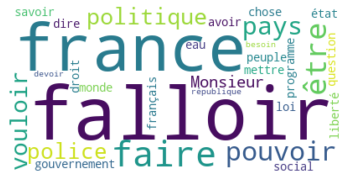

In [ ]:
lemat_jlm = " ".join(df_tweets.loc[df_tweets.user_id=="JLMelenchon", "text_preprocess"])
print("Wordcloud des mots lemmatis√©s de l'ensemble des tweets de Jean-Luc M√©lenchon")
create_wordcloud(lemat_jlm, 30)

Wordcloud des mots lemmatis√©s de l'ensemble des tweets de Marine Le Pen


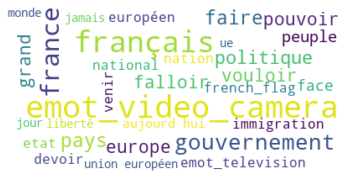

In [ ]:
lemat_mlp = " ".join(df_tweets.loc[df_tweets.user_id=="MLP_officiel", "text_preprocess"])
print("Wordcloud des mots lemmatis√©s de l'ensemble des tweets de Marine Le Pen")
create_wordcloud(lemat_mlp, 30)

C'est bien beau, mais c'est difficile √† analyser, et surtout √† comparer... \
On va utiliser scattertext pour comparer r√©ellement le vocabulaire des 2 politiques.

## **4. Scattertext**

Gr√¢ce √† Scattertext, on va pouvoir comparer de mani√®re visuelle la distinction de vocabulaire utilis√© par MLP et JLM. 


On doit d'abord construire un corpus avec nos donn√©es : 
- donner la variable de cat√©gorie 
- donner la variable du texte

On peut rajouter le partie ```.compact(st.AssociationCompactor(4000))``` pour ne prendre en compte que les 4000 mots les plus importants dans le scattertext.

**TODO** : cr√©er le corpus avec la fonction donn√©e ci-dessous

In [ ]:
# on cr√©e un objet corpus pour scattertext
corpus = st.CorpusFromPandas(data_frame = df_tweets.loc[df_tweets.user_id != "EmmanuelMacron"],
                             category_col = "user_id",
                             text_col = "text_preprocess",
                             nlp = nlp).build().compact(st.AssociationCompactor(4000))

Une fois le corpus cr√©√©, on peut cr√©er le html avec le scattertext.
 
On utilise la fonction ```st.produce_scattertext_explorer``` en donnant les param√®tres vus pendant le cours : 
- term_ranker
- term_scorer
- transform 

**TODO** : remplir la fonction en r√©fl√©chissant aux param√®tres que vous voulez tester.

In [ ]:
# On cr√©e le html du scattertext
html = st.produce_scattertext_explorer(  corpus
                                       , category                  = 'JLMelenchon'
                                       , category_name             = 'Jean Luc M√©lenchon'
                                       , not_category_name         = 'Marine Le Pen'
                                       , minimum_term_frequency    = 10
                                       , pmi_threshold_coefficient = 1
                                       , term_ranker               = st.AbsoluteFrequencyRanker
                                       , transform                 = st.Scalers.dense_rank
                                       , term_scorer               = st.RankDifference() 
#on peut √©galemet tester le term_scorer ScaledFscore : st.ScaledFScorePresets(beta=1, one_to_neg_one=True)
                                       , width_in_pixels           = 1000
                                       )

# On enregistre le html
open("tweets_visualisation.html", 'wb').write(html.encode('utf-8'))

1387283

**TODO** : regarder le r√©sultat (il apparaitra normalement dans le dossier content du notebook) en t√©l√©chargeant le html (cela peut prendre un petit moment avant de s'afficher correctement).

**Question** : On peut voir :
- les mots "stopwords" apparaitre en haut √† droite : des verbes ainsi que des mots tr√®s utilis√©s dans le langage politique ("pays", "politique")
- En bas √† droite, il y a les mots associ√©s √† MLP : "islamisme", "immigration", "nation", "fronti√®re", drapeau fran√ßais, et √©mojis
- En haut √† gauche, il y a les mots associ√©s √† JLM : "dette", "monsieur", "police", "programme", "commun", "insoumis"

## **5. Mod√©lisation**

On souhaite pr√©dire si un tweet provient du compte de Marine Le Pen, de Jean Luc M√©lenchon ou d'Emmanuel Macron. Pour cela, on a besoin de : 
- Cr√©er un √©chantillon train / dev
- pr√©parer le text (pr√©processing)
- cr√©er des features (plusieurs m√©thodes : counts of words, tfidf ou autre)
- r√©aliser l'algorithme
- √©valuer la performance du mod√®le 

### Cr√©ation des √©chantillons 

**TODO** : cr√©er un √©chantillon train (70% du jeu de donn√©es total) et un √©chantillon test 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Utilisez la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html" >train_test_split</a></li>
  <li> Prenez la colonne d√©j√† tokenis√©s</li>
</p> 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_tweets["text_preprocess"],
                                                    df_tweets["user_id"], 
                                                    test_size=0.3, 
                                                    random_state=123)

In [ ]:
# on v√©rifie que la r√©partition entre les user 
print(y_train.value_counts(normalize=True))
print("\n")
print(y_test.value_counts(normalize=True))

EmmanuelMacron    0.372840
MLP_officiel      0.339402
JLMelenchon       0.287758
Name: user_id, dtype: float64


EmmanuelMacron    0.385782
MLP_officiel      0.317295
JLMelenchon       0.296922
Name: user_id, dtype: float64


Les donn√©es sont plut√¥t √©quilibr√©es 

### Mod√®le de r√©gression multinomiale sans gridsearch 

- Transformer le texte de X_train et X_test en vecteurs pour le mod√®le
- Utiliser la r√©gression logistique multinomiale avec les param√®tres par d√©faut
- Regarder les hyperparam√®tres par d√©faut s√©lectionn√©s
- Regarder le score sur l'√©chantillon test

**#TODO** : transformer X_train pour que ce ne soit plus des tweets, mais des vecteurs gr√¢ce √† <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html" >TfidfVectorizer</a> (vous pouvez regarder les param√®tres associ√©s √† la fonction)

In [ ]:
#TODO
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train)

La fonction TfidfVectorizer a des param√®tres que vous pouvez choisir : 
- Combien de n-grams : vous consid√©rez mot par mot ou bien √©galement des groupes de 2 mots
- max_df : si vous voulez enlever un pourcentage de mots les plus fr√©quents
- min_df : si vous voulez enlever un pourcentage de mots les moins fr√©quents

In [ ]:
# vous pouvez tester avec ngram_range =(1,2) ou ngram_range=1, 
# pour voir le nombre de variables cr√©√©es dans le X_train 
# (attention, faites retourner le train_test_split avant)
X_train.shape

(5383, 68305)

**#TODO** : cr√©er le mod√®le de r√©gression logistique (OVR) et entrainer le mod√®le sur les donn√©es d'apprentissage

In [ ]:
# initialiser le mod√®le 
model = LogisticRegression(multi_class="ovr")

# entrainer le mod√®le avec les donn√©es d'apprentissage
model_without_grids = model.fit(X_train, y_train)

In [ ]:
# vous pouvez voir les param√®tres du mod√®le 
model_without_grids

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Attention, la r√©gression logistique de scikit learn permet de faire des mod√®les plus complexes qu'une r√©gression logistique normale que vous avez vu en cours : avec les param√®tres "penalty", vous cr√©er en fait un mod√®le de r√©gression logistique p√©nalis√© (ridge ou lasso). \
<a href="https://towardsdatascience.com/the-basics-logistic-regression-and-regularization-828b0d2d206c" >article sur r√©gression logistique p√©nalis√©e</a> \
<a href="https://towardsdatascience.com/penalized-regression-with-classification-f60bc663e8dc" >autre article</a>




**#TODO** : Regarder la performance du mod√®le sur l'√©chantillon test (accuracy)

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> N'oubliez pas de transformer le texte de l'√©chantillon test en vecteur en amont</li>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">score</a>  du mod√®le</li>
  
</p> 

In [ ]:
X_test = vectorizer.transform(X_test)
model_without_grids.score(X_test, y_test) 
# Mon r√©sultat est : 0.818

0.8183788469874296

**#TODO** : regarder plus en d√©tail ce que donne le mod√®le : 

In [ ]:
print("le 1er tweet de l'√©chantillon test a √©t√© pr√©dit : ")
print(model_without_grids.predict(X_test[0]))

le 1er tweet de l'√©chantillon test a √©t√© pr√©dit : 
['MLP_officiel']


In [ ]:
print(model_without_grids.classes_) # pour conna√Ætre l'ordre des classes / des mod√®les
model_without_grids.predict_proba(X_test[0])

['EmmanuelMacron' 'JLMelenchon' 'MLP_officiel']


array([[0.24281623, 0.04187058, 0.7153132 ]])

**Question** : que retourne la ligne de code ci-dessus ?

**R√©ponse** : les r√©sultats des 3 mod√®les de r√©gression logistique que scikit learn a fait tourner (car on est en One VS rest). 

On voit donc que le 3e mod√®le qui pr√©dit MLP VS reste, donne la probabilit√© la plus √©lev√©e (0.71 dans mon cas). Scikit learn pr√©dit donc que le 1er tweet vient du compte de MLP

### Mise en Gridsearch

On veut mettre en place une gridsearch pour s√©lectionner les meilleurs hyperparam√®tres qu'on a choisi d'√©valuer via la m√©thode de cross-validation : 
- on √©tablit d'abord la grille de hyperparam√®tres que l'on veut tester
- on effectue la gridsearch
- on regarde les r√©sultats sut l'√©chantillon test

In [ ]:
parameters = {u'C' : (1,20,50), # param√®tre devant coefficient de p√©nalisation (penalty)
              u'penalty' : ['l1', 'l2'], # si c'est une r√©gression lasso / ridge
              u'max_iter' : [500]
              }

**#TODO** : Entrainer la gridsearch avec les hyperparam√®tres ci-dessus sur les donn√©es d'apprentissage avec de la cross validation


<details>    
<summary>
    <font size="3"**texte en gras** color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">GridSearchCV</a></li>
  
</p> 

In [ ]:
grid_search = GridSearchCV(LogisticRegression(multi_class="ovr"), 
                           parameters,
                           cv=10,  # cross validation de 10 √©chantillons
                           n_jobs=-1,
                           verbose=1)

In [ ]:
print(u"Performing grid search...")
print(u"parameters:")
print(parameters) 
t0 = time() 
grid_search.fit(X_train, y_train)
print(u"done in %0.3fs" % (time() - t0))
print(u'')
print(u'DEVELOPMENT SET')
print(u"Best score on the train set: %0.3f" % grid_search.best_score_)
print(u"Best parameters set on the train set:") 
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()): 
  print(u"\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'C': (1, 20, 50), 'penalty': ['l1', 'l2'], 'max_iter': [500]}
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   52.5s finished


done in 58.851s

DEVELOPMENT SET
Best score on the train set: 0.832
Best parameters set on the train set:
	C: 50
	max_iter: 500
	penalty: 'l2'


Le mod√®le avec les hyperparam√®tres s√©lectionn√©s par cross validation a une performance de 0.833 en cross validation

**#TODO** : on √©value la performance en calculant l'accuracy du mod√®le de gridsearch sur l'√©chantillon test



In [ ]:
grid_search.score(X_test, y_test)

0.8274815778066753

Sur l'√©chantillon test, le mod√®le a une performance de 0.829

### Evaluation de la performance du mod√®le 

On va calculer la matrice de confusion sur l'√©chantillon test

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html" >plot_confusion_matrix</a></li>
  
</p> 

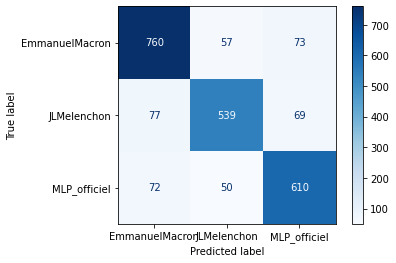

In [ ]:
#matrice de confusion
#confrontation entre Y obs. sur l‚Äô√©ch. test et la pr√©diction
disp = plot_confusion_matrix(grid_search, 
                             X_test, 
                             y_test,
                             cmap=plt.cm.Blues,
                             values_format=".3g")
plt.show()

**#TODO** : Interpr√©ter les r√©sultats 

**Question** : Sur l'ensemble des tweets de JLM, combien (pourcentage) ont bien √©t√© pr√©dits JLM ?  

**R√©ponse** : 79% des tweets de JLM ont √©t√© pr√©dits JLM par le mod√®le. 
``` 
539/(539+77+69) 
```

In [ ]:
#On peut aussi retrouver le r√©sultat via cette fonction
print(classification_report(y_test, grid_search.predict(X_test)))

                precision    recall  f1-score   support

EmmanuelMacron       0.84      0.85      0.84       890
   JLMelenchon       0.83      0.79      0.81       685
  MLP_officiel       0.81      0.83      0.82       732

      accuracy                           0.83      2307
     macro avg       0.83      0.82      0.83      2307
  weighted avg       0.83      0.83      0.83      2307



### Test sur des nouvelles donn√©es :

Ces quelques tweets ont √©t√© r√©cup√©r√©s apr√®s que la base de donn√©es ait √©t√© r√©cup√©r√©e. Ce sont donc des nouvelles donn√©es que le mod√®le n'a jamais vu.

**#TODO** : Qui a publi√© ces tweets ? 

In [ ]:
new_tweets = ["On ne peut que condamner le coup d‚ÄôEtat militaire en Birmanie, qui renvoie ce pays vers une situation que l‚Äôon esp√©rait d√©pass√©e. Le fonctionnement constitutionnel r√©gulier doit √™tre assur√©; Mme Aung San Suu KyI et les personnes arr√™t√©es doivent √™tre lib√©r√©es sans d√©lai. MLP", 
              "Non ! Les chemins de la raison ne s'ouvrent pas √† la faux. Non ! La porte de l'universel ne s'ouvre pas √† coups de pieds. Non ! L'amour de la R√©publique, comme tout amour, ne vaut rien sous la menace.", 
              "C‚Äôest par notre vigilance collective que nous r√©ussirons. Tester, au moindre sympt√¥me. Alerter, pour limiter la propagation. Prot√©ger, en respectant l‚Äôisolement.",
              "Lib√©r√©, d√©livr√©, je ne mentirai plus jamais ! C'est d√©cid√© je m'en vais. L'hiver s'installe doucement dans la nuit, la neige est reine √† son tour. Un royaume de solitude.",
              "Oui, ma g√¢t√©e, RS4 gris nardo, bien s√ªr qu'ils m'ont rat√© (gros, bien s√ªr). Soleil dans la bulle, sur le Prado, Shifter pro' (Shifter pro'). Contre-sens (ah), ma ch√©rie, tu es √† contre-sens"]

In [ ]:
X_mystere = pd.DataFrame(new_tweets, columns=["text"])
X_mystere = X_mystere.text.apply(lambda row : preprocess_tweet(row, lemmatizing=True))
X_tfidf_mystere = vectorizer.transform(X_mystere)
grid_search.predict(X_tfidf_mystere)

array(['MLP_officiel', 'JLMelenchon', 'EmmanuelMacron', 'EmmanuelMacron',
       'MLP_officiel'], dtype=object)

**R√©ponse attendue** :

```
array(['MLP_officiel', 'JLMelenchon', 'EmmanuelMacron', 'EmmanuelMacron',
       'MLP_officiel'], dtype=object)
```